# References: 
Data Source: https://www.kaggle.com/datasets/ahmedmoorsy/facial-expression/data </br>
Detection Model Paper: https://openaccess.thecvf.com/content_cvpr_2013/papers/Sun_Deep_Convolutional_Network_2013_CVPR_paper.pdf </br>
Face & Point Detection: https://mmlab.ie.cuhk.edu.hk/archive/CNN_FacePoint.htm 


## /******************************************** Part 1 ********************************************/
## Facial Key Points Detection

In [599]:

# Import the necessary packages
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [600]:
print(tf.__version__)

2.16.1


In [601]:
'''
data.csv: This Facial Key Points dataset contains around 2140 images.
There should be 2140 rows × 31 columns in the file. The last columns contain the actual values for the pixels for the actual image.
'''
# Load facial key points data file
keyfacial_df = pd.read_csv('dataset/data.csv')

# Load data state and image number in the file
keyfacial_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,...,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,...,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,...,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,...,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [602]:
# Obtain relavant information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [603]:
# Check if null values exist in the dataframe. It will be a good sign that there's no null element in the data.
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [604]:
# The Last column "Image" contains all the value of the pixels of the image in the format of 1-D array.
keyfacial_df['Image'].shape

(2140,)

In [605]:
# Separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

In [606]:
# Obtain the average, minimum and maximum values for 'right_eye_center_x'
keyfacial_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/3803779299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


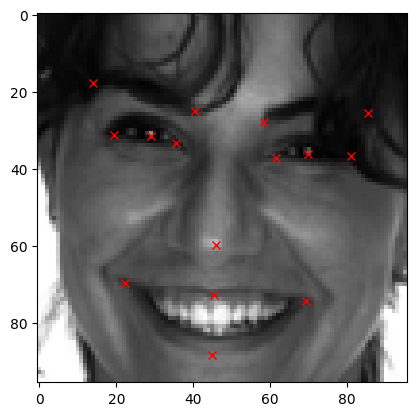

In [607]:
# Plot a random image from the dataset along with 15 facial keypoints, using plt.imshow.
# Since x-coordinates are in even columns and y-coordinates are in odd columns, we can access their value using .loc command
i = np.random.randint(1, len(keyfacial_df))             # Selct a random image from the dataset
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')     # Specify the color map to be "gray"

# Show the actual key facial points on top of the image
for j in range(1, 31, 2):
        # Print out the x&y as pair one by one, in the color of "red" and in the shape of "x.
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/1043478010.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


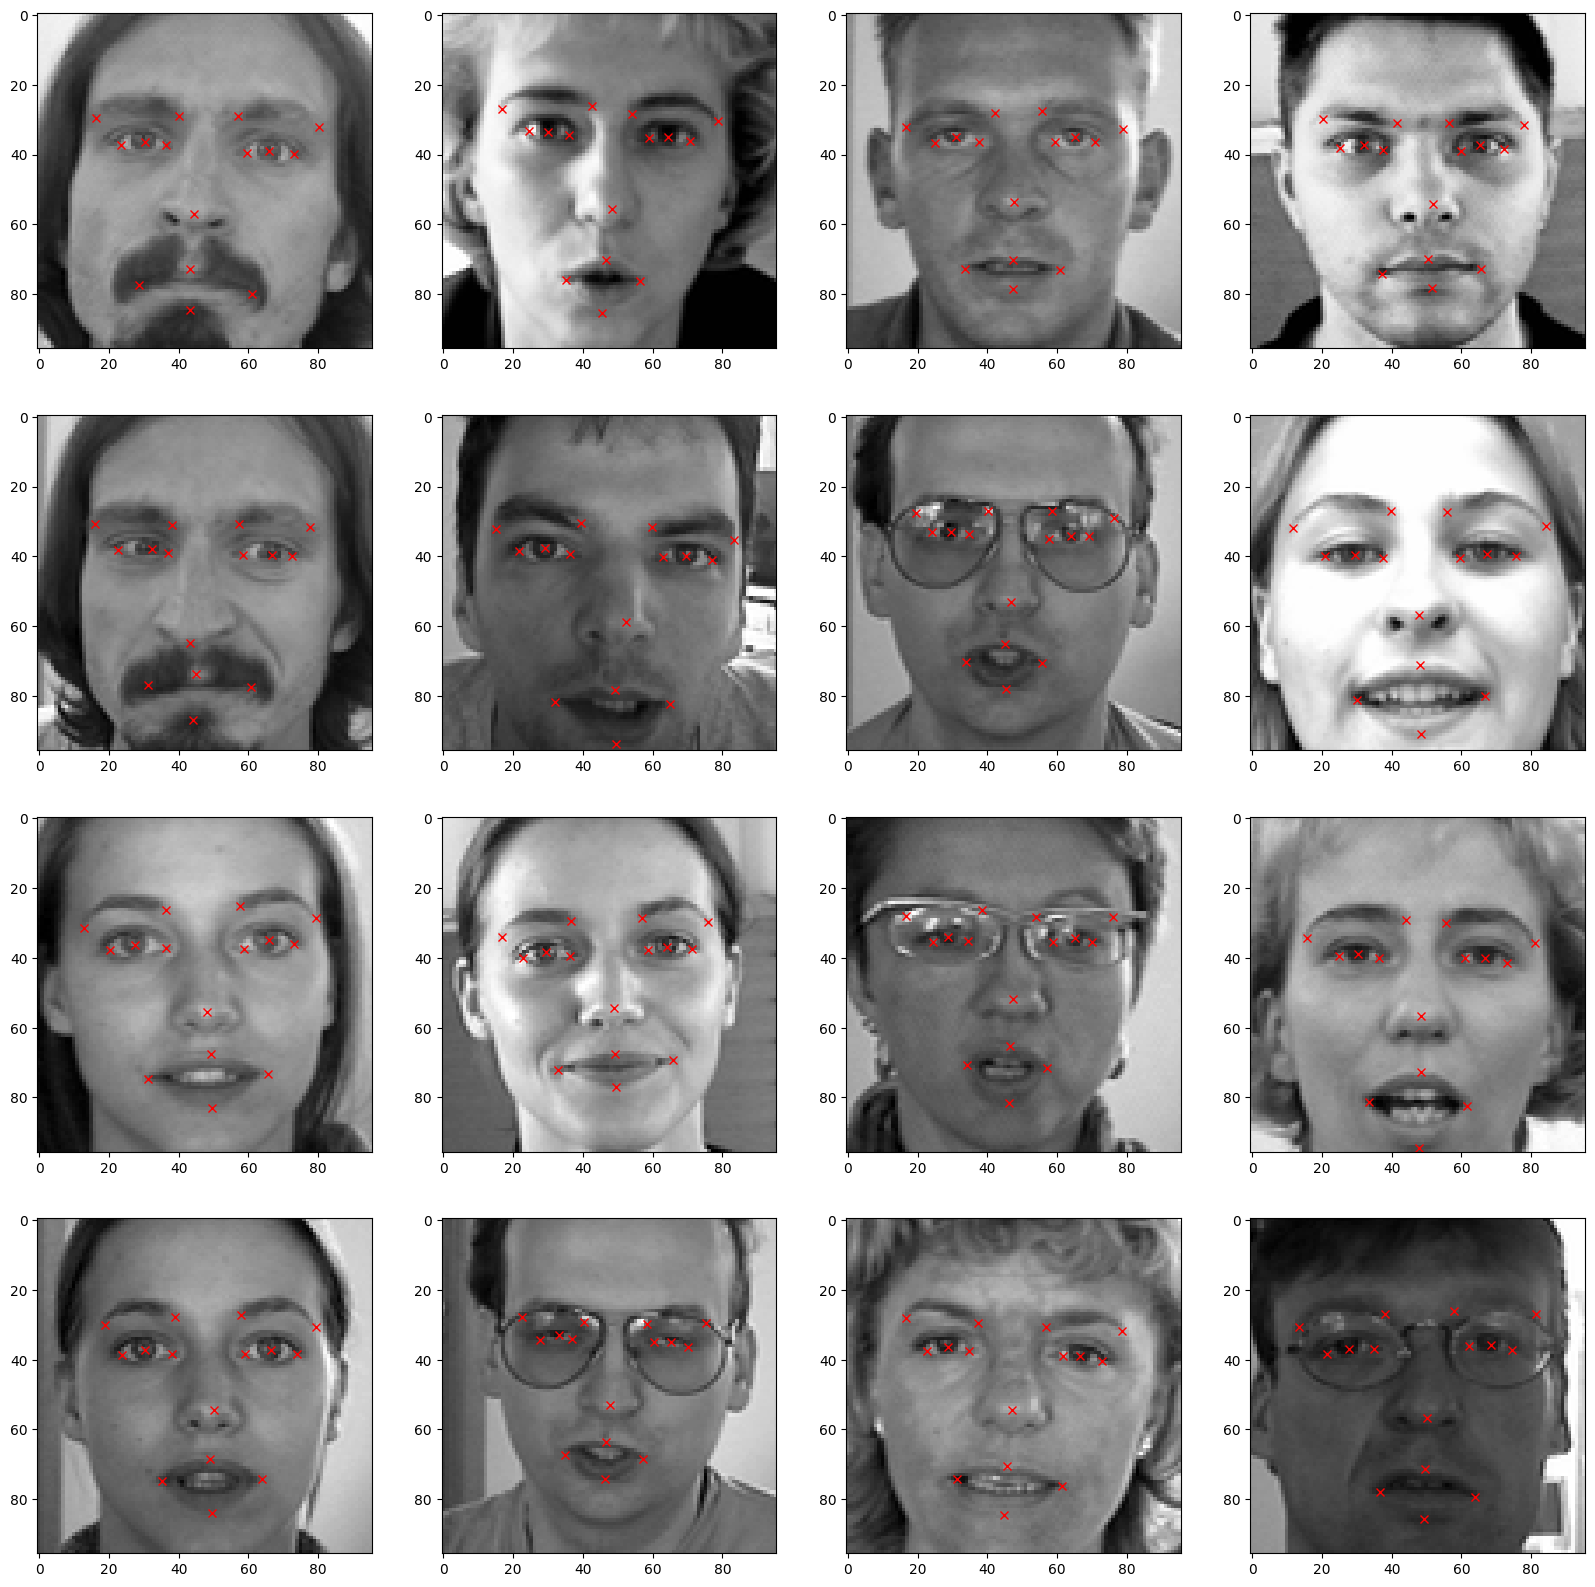

In [608]:
# Data check 1: View images in a grid format, containng 4 x 4 images
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

In [609]:
# Data check 2: randomly visualize 64 new images along with their cooresponding key points
# import random
# # View more images in a grid format
# fig = plt.figure(figsize=(20, 20))

# for i in range(64):
#     k = random.randint(1, len(keyfacial_df))
#     ax = fig.add_subplot(8, 8, i + 1)
#     image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
#     for j in range(1,31,2):
#         plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')

In [610]:
'''
Perform Image Augmentation to improve the generalization capability of the model.
For instance, flip the image vertically or horizontally, increase or darken the brightness of the image, zoom the image, etc. 
By doing this, we can avoid the model "memorizing" the data.
'''
# Create a new copy of the dataframe
import copy
keyfacial_df_copy1 = copy.copy(keyfacial_df)

# Obtain the columns in the dataframe
columns = keyfacial_df_copy1.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/1941861547.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')


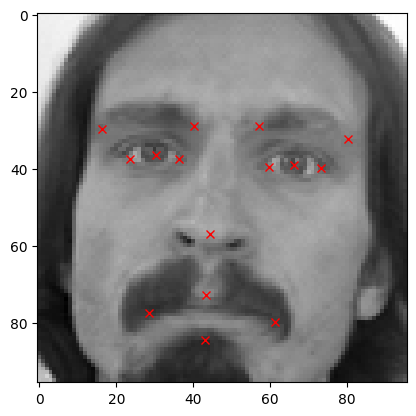

In [611]:
# Argumentation 1: Horizontal Flip - flip the images along y axis
keyfacial_df_copy1['Image'] = keyfacial_df_copy1['Image'].apply(lambda x: np.flip(x, axis = 1))

# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change: subtract the initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:  # Select only even-index columns
    keyfacial_df_copy1[columns[i]] = keyfacial_df_copy1[columns[i]].apply(lambda x: 96. - float(x))
    
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/1010539847.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy1.loc[0][j-1], keyfacial_df_copy1.loc[0][j], 'rx')


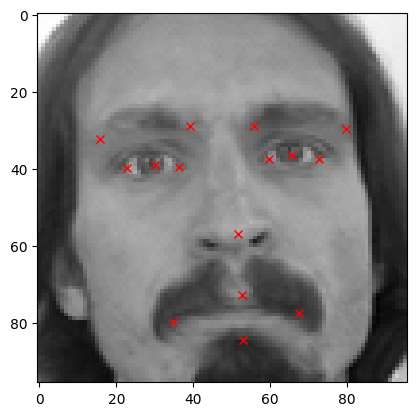

In [612]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy1['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy1.loc[0][j-1], keyfacial_df_copy1.loc[0][j], 'rx')

In [613]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy1))
# Show the updated total number of images: the original ones + the ones that were argumented
augmented_df.shape

(4280, 31)

/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/1372719862.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy2.loc[0][j-1], keyfacial_df_copy2.loc[0][j], 'rx')


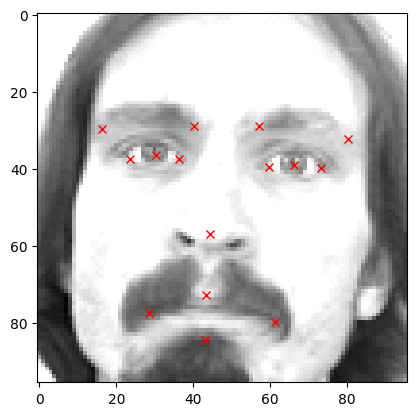

In [614]:
# Argumentation 2: Randomly increase the brightness of the images
# Multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# Clip the value between 0 and 255

import random
keyfacial_df_copy2 = copy.copy(keyfacial_df)
keyfacial_df_copy2['Image'] = keyfacial_df_copy2['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))

# Show Image with increased brightness
plt.imshow(keyfacial_df_copy2['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy2.loc[0][j-1], keyfacial_df_copy2.loc[0][j], 'rx')

In [615]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy2))
# Show the updated total number of images: the original ones + the ones that were argumented
augmented_df.shape

(6420, 31)

/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/3197404705.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy3.loc[0][j-1], keyfacial_df_copy3.loc[0][j], 'rx')


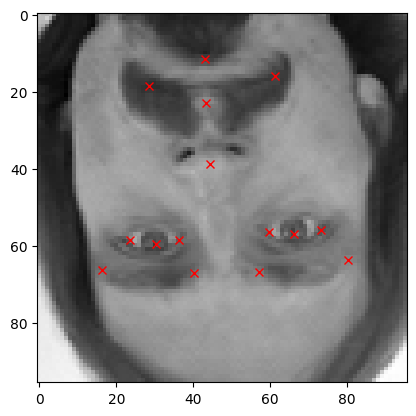

In [616]:
# Argumentation 3: Vertically Flip - flip the images along x axis
keyfacial_df_copy3 = copy.copy(keyfacial_df)
keyfacial_df_copy3['Image'] = keyfacial_df_copy3['Image'].apply(lambda x: np.flip(x, axis = 0))

# Since we are flipping vertically, x coordinate values would be the same
# Only y coordiante values would change: subtract the initial y-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 1:  # Select only odd-index columns
    keyfacial_df_copy3[columns[i]] = keyfacial_df_copy3[columns[i]].apply(lambda x: 96. - float(x))
    
#  Show the vertically flipped image
plt.imshow(keyfacial_df_copy3['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy3.loc[0][j-1], keyfacial_df_copy3.loc[0][j], 'rx')


In [617]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy3))
# Show the updated total number of images: the original ones + the ones that were argumented
augmented_df.shape

(8560, 31)

In [618]:
'''
Perform Data Normalization and Training Data Preparation
Instead of using pixel from 0(black) to 255(white), we want to make the pixel range between 0 and 1.
'''
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [619]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [620]:
# Split the data into train(80%) and test(20%) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Check training data number
X_train.shape

(6848, 96, 96, 1)

In [621]:
# Check testing data number
X_test.shape

(1712, 96, 96, 1)

In [622]:
'''
Build Deep Residual Neural Network Key Facial Points Detection Model
Step 1: Build the Rest Block
Step 2: Build the Final Model
'''
from tensorflow.keras.layers import  Activation, BatchNormalization, Add,MaxPool2D, Conv2D
# Res-Block Structure: Input -> Convolution Block -> Identity Block -> Identity Block -> Output
def res_block(X, filter, stage):

  # 1. Convolutional_block (Main Path + Short Path)
  X_copy = X

  f1 , f2, f3 = filter

  # 1.1 Main Path (Conv2D -> MaxPool2D -> BatchNorm, Relu -> Conv2D-kernel(3*3) -> BatchNorm, Relu -> Conv2D -> BatchNorm)
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X) # Apply convolution in 2D dimensions
  X = MaxPool2D((2,2))(X)   # Remove for Experiment Part 2
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # 1.2 Short path (Conv2D -> MaxPool2D -> BatchNorm)
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)   # Remove for Experiment Part 2
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # 1.3 ADD (Main Path + Short Path)
  X = Add()([X,X_copy])
  # 1.4 Activation Function
  X = Activation('relu')(X)


  # 2. Identity Block 1
  X_copy = X

  # 2.1 Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # 2.2 ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)


  # 3. Identity Block 2
  X_copy = X

  # 3.1 Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # 3.2 ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [623]:
# Final Model Structure: Input -> Zero Padding -> Conv2D -> BatchNorm, Relu -> MaxPool2D -> Res-Block -> 
# Res-Block -> AveragePooling2D --> Flatten() --> denseLayer, Relu, Dropout --> DenseLayer, Relu, Dropout --> 
# DenseLayer, Relu --> Output[Key Facial Points/Emotion]
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, ZeroPadding2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model

# Final Model
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# # 4 - stage
# X = res_block(X, filter= [256,256,1024], stage= 4)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer(Dropout: A regularization technique to ensure the generalization capability of the network)
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)   # Drop 20% of the neurons: avoid having the interdependency between the neurons
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)

model_1_facialKeyPoints = Model(inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_23   │ (None, 102, 102,  │          0 │ input_layer_23[0… │
│ (ZeroPadding2D)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 48, 48,    │      3,200 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 48, 48,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_482      │ (None, 48, 48,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_125   │ (None, 23, 23,    │          0 │ activation_482[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_a        │ (None, 23, 23,    │      4,160 │ max_pooling2d_12… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_126   │ (None, 11, 11,    │          0 │ res_2_conv_a[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_a         │ (None, 11, 11,    │        256 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_483      │ (None, 11, 11,    │          0 │ bn_2_conv_a[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_b        │ (None, 11, 11,    │     36,928 │ activation_483[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_b         │ (None, 11, 11,    │        256 │ res_2_conv_b[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_484      │ (None, 11, 11,    │          0 │ bn_2_conv_b[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_copy     │ (None, 23, 23,    │     16,640 │ max_pooling2d_12… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_c        │ (None, 11, 11,    │     16,640 │ activation_484[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_127   │ (None, 11, 11,    │          0 │ res_2_conv_copy[… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_c         │ (None, 11, 11,    │      1,024 │ res_2_conv_c[0][

 Total params: 18,016,286 (68.73 MB)

 Trainable params: 18,007,710 (68.69 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [624]:
'''
Compile and train Key Facial Points Detection model
'''
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# More information on Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam, metrics = ['accuracy'])

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "dataset/FacialKeyPoints_weights.keras", verbose = 1, save_best_only = True)

In [625]:
# Fit the training data to the model
# Batch Size: how many images are being feeding to the model at once
# Experiments: Adjust the batch size, the epochs or validation split
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 32, epochs = 2, validation_split = 0.1, callbacks=[checkpointer])

Epoch 1/2
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3225 - loss: 638.2841
Epoch 1: val_loss improved from inf to 840.73743, saving model to dataset/FacialKeyPoints_weights.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.3235 - loss: 636.6884 - val_accuracy: 0.3328 - val_loss: 840.7374
Epoch 2/2
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6826 - loss: 152.8009
Epoch 2: val_loss improved from 840.73743 to 314.57315, saving model to dataset/FacialKeyPoints_weights.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.6827 - loss: 152.7436 - val_accuracy: 0.5241 - val_loss: 314.5732


In [626]:
# save the model architecture to json file for future use
model_json = model_1_facialKeyPoints.to_json()
with open("dataset/FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)


In [627]:
'''
Assess the trained Key Facial Points Detection Model performance
'''
with open('dataset/FacialKeyPoints-model_best.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('dataset/FacialKeyPoints_weights_best.keras')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

# Evaluate the model
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8525 - loss: 76.5925
Accuracy : 0.8428738117218018


In [628]:
# Get the model keys
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

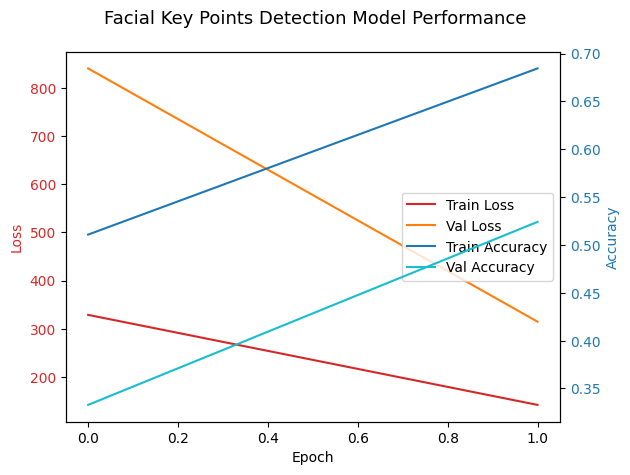

In [629]:
# Plot the training artifacts
fig, ax1 = plt.subplots()
fig.suptitle('Facial Key Points Detection Model Performance', fontsize=13)

color = 'tab:red'
ax2 = ax1.twinx()  

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color='tab:orange', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Accuracy')
line4, = ax2.plot(history.history['val_accuracy'], color='tab:cyan', label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

lines = [line1, line2, line3, line4]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

fig.tight_layout()  
plt.show()


## /******************************************** Part 2 ********************************************/
## Facial Emotion Reconigtion

#### Using the identical dataset for both ViT and CNN models: fer2013_csv.csv

In [630]:

# Import & Explore Dataset For Facial Expression Reconigtion

# Read the csv files for the facial expression data
facialexpression_df = pd.read_csv('dataset/fer2013_csv.csv')

# Data check: show the DataFrame
facialexpression_df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [631]:
facialexpression_df['pixels'][0]    # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [632]:
# Function to convert pixel values in string format to array format
# Reshape the data into a 48x48 pixels
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [633]:
# Resize images from (48, 48) to (96, 96), so that both models are trained in the same image size
def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [634]:
# Apply the string2array function
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: string2array(x))

# Apply the resize function
facialexpression_df['pixels'] = facialexpression_df['pixels'].apply(lambda x: resize(x))

In [635]:
# Data check: Display the first 5 rows of the facialexpression DataFrame
facialexpression_df.head()

,emotion,pixels,Usage
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85....",Training
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ...",Training
2,2,"[[232.82552, 229.81886, 225.59953, 200.68909, ...",Training
3,4,"[[23.061905, 25.50914, 29.47847, 33.99843, 36....",Training
4,6,"[[4.771652, 3.3384705, 0.9779358, -0.45524597,...",Training


In [636]:
# Data check: show the number of rows and columns in the facialexpression DataFrame
facialexpression_df.shape

(35887, 3)

In [637]:
# Data check: Calculate the total number of null values in each column of DataFrame
facialexpression_df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [638]:
# Define a dictionary to map the numerical labels to their corresponding emotions
label_to_text = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

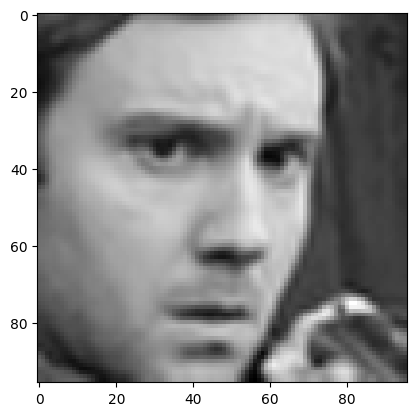

In [639]:
# Data check: Visualize the first image in the dataframe and make sure that the image is not distorted by resizing or reshaping operations
plt.imshow(facialexpression_df['pixels'][0], cmap = 'gray')

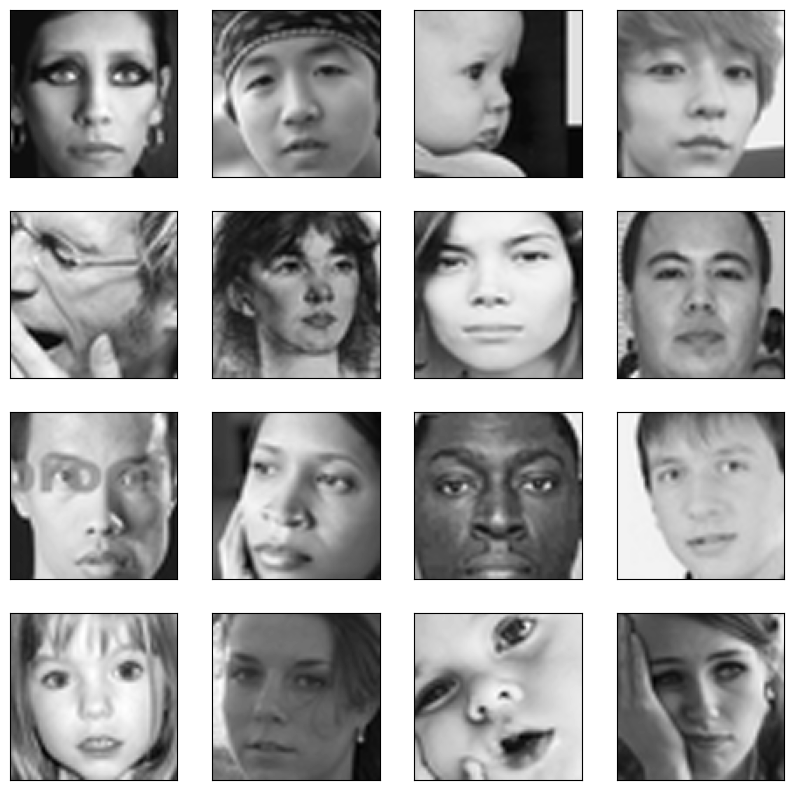

In [640]:
# Data check: visualize the first 16 images of a given emotion

# Filter the DataFrame to only include rows where the label is 0
label_df = facialexpression_df[facialexpression_df['emotion'] == 6] # 6 is the label for "Neutral"

# Get the first 16 images and reset the index
images = label_df['pixels'][:16].reset_index(drop=True)

# Create a new figure
plt.figure(figsize=(10, 10))

# Loop over the images and add each one to a subplot in the 4x4 grid
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')

plt.show()

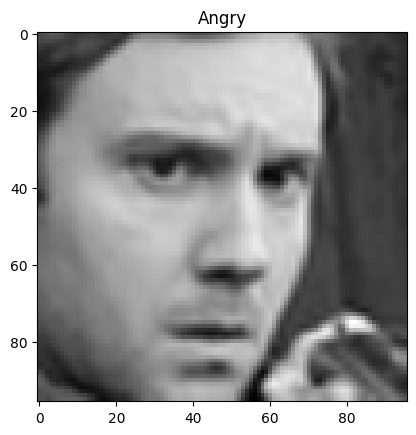

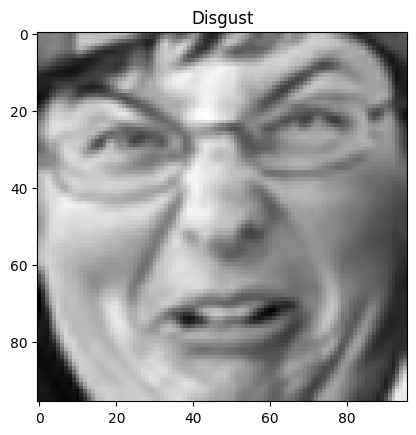

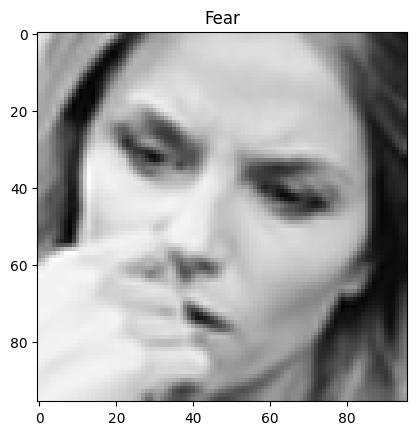

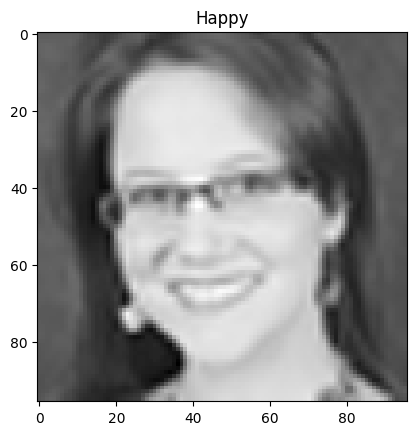

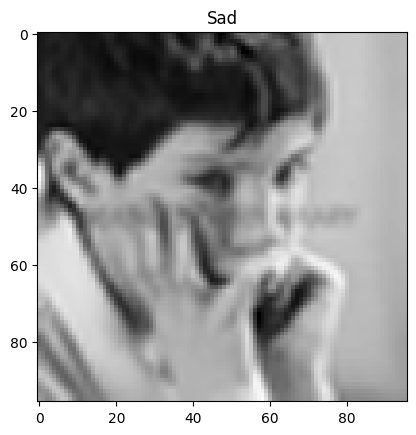

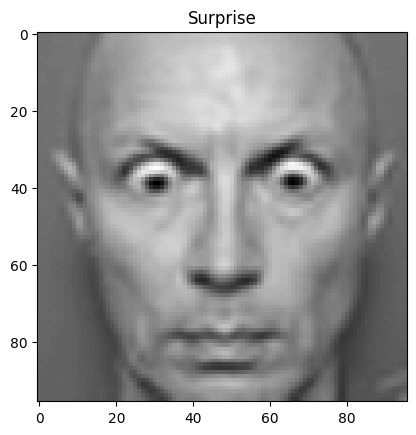

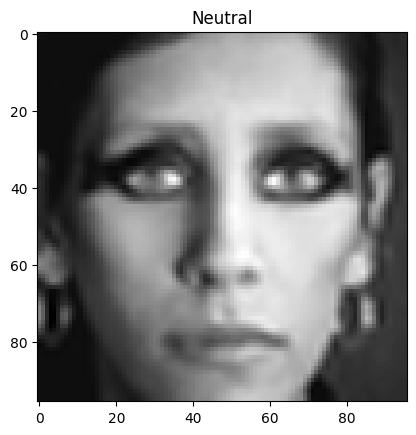

In [641]:
# Data Check: visualize the images and plot corresponding labels
emotions = [0, 1, 2, 3, 4, 5, 6]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1] # Show one sample image of each emotion
  img = data['pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [642]:
# Data check: show the number of images for each emotion
facialexpression_df.emotion.value_counts().index
facialexpression_df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/3891131053.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts(), palette="hsv")


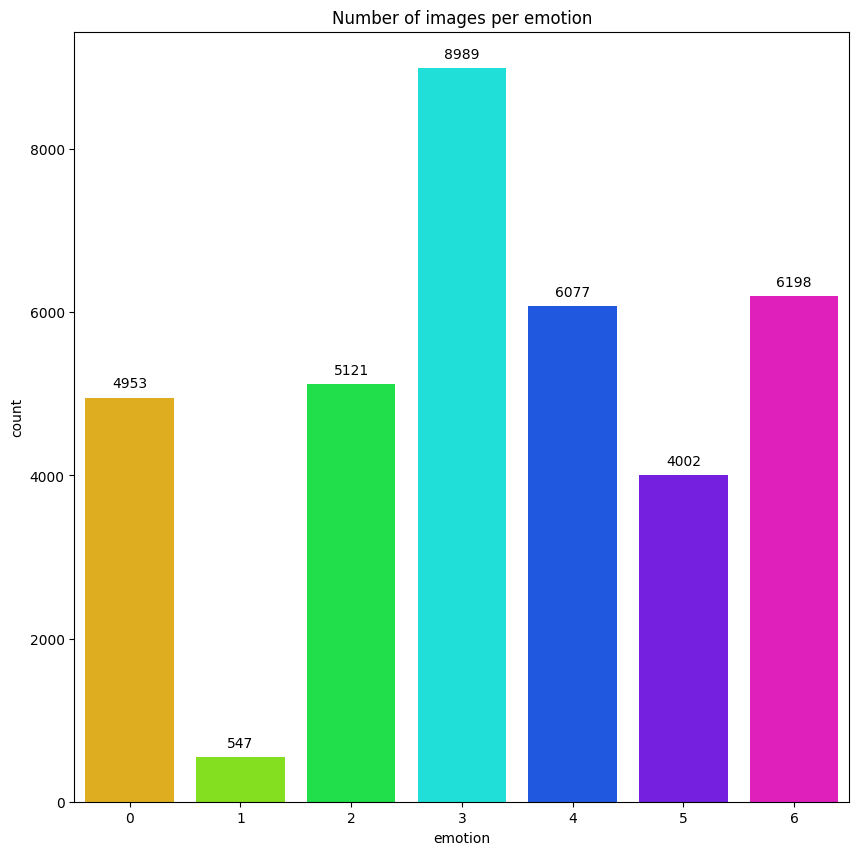

In [643]:
# Data check: plot bar chart to outline how many images are present per emotion.
# Purpose: to check if the dataset is balanced or not.
plt.figure(figsize=(10,10))

# Add the exact number to each bar
barplot = sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts(), palette="hsv")
plt.title('Number of images per emotion')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

plt.show()

In [644]:
'''
Perform data preparation and image argumentation
'''
# split the dataframe in to features and labels
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

X = facialexpression_df['pixels']
y = to_categorical(facialexpression_df['emotion'])

In [645]:
# Stack the list of arrays `X` along a new axis, which creates a 3D array where each 2D array from the list forms a slice along the new axis.
X = np.stack(X, axis = 0)
# Reshape the 3D array `X` into a 4D array(35887 images of 96x96 with 1 color channel).
X = X.reshape(35887, 96, 96, 1) # 1: only one color channel

print(X.shape, y.shape)

(35887, 96, 96, 1) (35887, 7)


In [646]:
# Split the dataframe in to train, test and validation data frames
from sklearn.model_selection import train_test_split

# split the dataframe based on the "Usage" column
X_train = X[facialexpression_df['Usage'] == 'Training']
y_train = y[facialexpression_df['Usage'] == 'Training']
X_Test = X[facialexpression_df['Usage'] == 'PrivateTest']
y_Test = y[facialexpression_df['Usage'] == 'PrivateTest']

# split a portion from the training set to form the validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True)

# Data check
print("X_val:", X_val.shape, "    y_val:", y_val.shape)
print("X_Test:", X_Test.shape, "   y_Test:", y_Test.shape)
print("X_train:", X_train.shape, " y_train:", y_train.shape)

X_val: (5742, 96, 96, 1)     y_val: (5742, 7)
X_Test: (3589, 96, 96, 1)    y_Test: (3589, 7)
X_train: (22967, 96, 96, 1)  y_train: (22967, 7)


In [647]:
# # Calculate class weights
# classes = np.unique(np.argmax(y_train, axis=1))  # Extract classes from one-hot encoded y_train
# class_weights = compute_class_weight('balanced', classes=classes, y=np.argmax(y_train, axis=1))
# class_weight_dict = dict(enumerate(class_weights))

# # Data check
# print("classes: ", classes, "\n", "class_weights: ", class_weights, "\n", "class_weight_dict: ", class_weight_dict)


''' 
Alternative way to adjust the class weights
'''

# # Compute initial class weights
# classes = np.unique(np.argmax(y_train, axis=1))  # Extract classes from one-hot encoded y_train
# class_weights = compute_class_weight('balanced', classes=classes, y=np.argmax(y_train, axis=1))
# class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
# print("Initial class weights:", class_weight_dict)

# # Adjust class weights based on observed training results
# class_weight_dict[1] *= 2  # Significantly increase weight for 'Disgust' due to poor recall
# class_weight_dict[3] /= 1.5  # Slightly decrease weight for 'Happiness' if it is causing overfitting

# print("Adjusted class weights:", class_weight_dict)


' \nAlternative way to adjust the class weights\n'

In [648]:
# Image pre-processing: normalize the pixel values of the images to be between 0 and 1
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [649]:
# Image argumentation: method to adjust the balance of the dataset
# Check Keras documentation https://keras.io/api/preprocessing/image/ for image prepocessing
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [1.1, 1.5], # 1.0 does not affect image brightness; [0.5, 1.0] darken the image; [1.0, 1.5] brighten the image
    fill_mode = "nearest")

In [650]:
'''
Build Deep Residual Neural Network for Facial Emotion Reconigtion Model
'''
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, ZeroPadding2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model

# Define the input shape, which should be matched with the size in Facial Key Points Detection model
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Add Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# # 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(7, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model(inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_24   │ (None, 102, 102,  │          0 │ input_layer_24[0… │
│ (ZeroPadding2D)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 48, 48,    │      3,200 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 48, 48,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_501      │ (None, 48, 48,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_130   │ (None, 23, 23,    │          0 │ activation_501[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_a        │ (None, 23, 23,    │      4,160 │ max_pooling2d_13… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_131   │ (None, 11, 11,    │          0 │ res_2_conv_a[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_a         │ (None, 11, 11,    │        256 │ max_pooling2d_13… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_502      │ (None, 11, 11,    │          0 │ bn_2_conv_a[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_b        │ (None, 11, 11,    │     36,928 │ activation_502[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_b         │ (None, 11, 11,    │        256 │ res_2_conv_b[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_503      │ (None, 11, 11,    │          0 │ bn_2_conv_b[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_copy     │ (None, 23, 23,    │     16,640 │ max_pooling2d_13… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_c        │ (None, 11, 11,    │     16,640 │ activation_503[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_132   │ (None, 11, 11,    │          0 │ res_2_conv_copy[… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_c         │ (None, 11, 11,    │      1,024 │ res_2_conv_c[0][

 Total params: 1,175,047 (4.48 MB)

 Trainable params: 1,166,471 (4.45 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [651]:
'''
Train the network.
Use the files saved from the facial key points model: FacialKeyPoints_weights_best.keras and FacialKeyPoints-model_best.json
'''
from keras.optimizers import Adam
adam = Adam()
model_2_emotion.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])

# Use early stopping to exit training if validation loss is not decreasing even after certain epochs(patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "dataset/FacialEmotion_weights.keras", verbose = 1, save_best_only=True)

In [652]:
# Fit the training data to the model
batch_size = 64
history = model_2_emotion.fit(
	train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data = (X_val, y_val),	# Perform cross validation
    steps_per_epoch = len(X_train) // batch_size,
	epochs = 100, 
    callbacks = [checkpointer, earlystopping],
    # class_weight = class_weight_dict	# Apply class weights
)

Epoch 1/100


/Users/AdelaFeng/Documents/CS_Studies/NEU_CS_Align/CS5100/Project/emotion_AI/emotional_AI/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2243 - loss: 2.0573
Epoch 1: val_loss improved from inf to 1.81841, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.2243 - loss: 2.0569 - val_accuracy: 0.1808 - val_loss: 1.8184
Epoch 2/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.2500 - loss: 1.7459

2024-04-25 02:23:10.899238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.81841
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2500 - loss: 1.7459 - val_accuracy: 0.1799 - val_loss: 1.8247
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2553 - loss: 1.8070
Epoch 3: val_loss improved from 1.81841 to 1.81050, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.2553 - loss: 1.8070 - val_accuracy: 0.2241 - val_loss: 1.8105
Epoch 4/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.2969 - loss: 1.7840

2024-04-25 02:23:58.842563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 1.81050 to 1.79436, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2969 - loss: 1.7840 - val_accuracy: 0.2342 - val_loss: 1.7944
Epoch 5/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2857 - loss: 1.7601
Epoch 5: val_loss did not improve from 1.79436
358/358 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.2857 - loss: 1.7600 - val_accuracy: 0.2478 - val_loss: 2.1373
Epoch 6/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.2969 - loss: 1.7663

2024-04-25 02:24:46.740581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_loss did not improve from 1.79436
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2969 - loss: 1.7663 - val_accuracy: 0.2612 - val_loss: 1.9166
Epoch 7/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3096 - loss: 1.7151
Epoch 7: val_loss improved from 1.79436 to 1.78425, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - accuracy: 0.3096 - loss: 1.7151 - val_accuracy: 0.2881 - val_loss: 1.7843
Epoch 8/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.4375 - loss: 1.5876

2024-04-25 02:25:34.885367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_loss did not improve from 1.78425
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4375 - loss: 1.5876 - val_accuracy: 0.2757 - val_loss: 1.8017
Epoch 9/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3169 - loss: 1.6986
Epoch 9: val_loss improved from 1.78425 to 1.63791, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.3169 - loss: 1.6986 - val_accuracy: 0.3535 - val_loss: 1.6379
Epoch 10/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.3906 - loss: 1.6282

2024-04-25 02:26:23.448897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_loss improved from 1.63791 to 1.62906, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3906 - loss: 1.6282 - val_accuracy: 0.3546 - val_loss: 1.6291
Epoch 11/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3339 - loss: 1.6680
Epoch 11: val_loss did not improve from 1.62906
358/358 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.3339 - loss: 1.6680 - val_accuracy: 0.3755 - val_loss: 1.6473
Epoch 12/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.2656 - loss: 1.6747

2024-04-25 02:27:11.342245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: val_loss did not improve from 1.62906
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2656 - loss: 1.6747 - val_accuracy: 0.3781 - val_loss: 1.6332
Epoch 13/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3423 - loss: 1.6489
Epoch 13: val_loss did not improve from 1.62906
358/358 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.3423 - loss: 1.6489 - val_accuracy: 0.3450 - val_loss: 1.7376
Epoch 14/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.4531 - loss: 1.6099

2024-04-25 02:28:00.016809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 14: val_loss did not improve from 1.62906
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4531 - loss: 1.6099 - val_accuracy: 0.3438 - val_loss: 1.7414
Epoch 15/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3484 - loss: 1.6351
Epoch 15: val_loss improved from 1.62906 to 1.54933, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.3484 - loss: 1.6351 - val_accuracy: 0.4190 - val_loss: 1.5493
Epoch 16/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.3281 - loss: 1.6478

2024-04-25 02:28:48.708783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_loss did not improve from 1.54933
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3281 - loss: 1.6478 - val_accuracy: 0.4138 - val_loss: 1.5707
Epoch 17/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3618 - loss: 1.6129
Epoch 17: val_loss improved from 1.54933 to 1.40320, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.3618 - loss: 1.6128 - val_accuracy: 0.4692 - val_loss: 1.4032
Epoch 18/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 43s 122ms/step - accuracy: 0.3438 - loss: 1.4967

2024-04-25 02:29:37.795843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 18: val_loss improved from 1.40320 to 1.40214, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3438 - loss: 1.4967 - val_accuracy: 0.4695 - val_loss: 1.4021
Epoch 19/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3653 - loss: 1.5987
Epoch 19: val_loss did not improve from 1.40214
358/358 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.3654 - loss: 1.5987 - val_accuracy: 0.4443 - val_loss: 1.4701
Epoch 20/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.3750 - loss: 1.5806

2024-04-25 02:30:27.476302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 20: val_loss did not improve from 1.40214
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3750 - loss: 1.5806 - val_accuracy: 0.4284 - val_loss: 1.4939
Epoch 21/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3724 - loss: 1.5807
Epoch 21: val_loss improved from 1.40214 to 1.38129, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 47s 131ms/step - accuracy: 0.3724 - loss: 1.5807 - val_accuracy: 0.4645 - val_loss: 1.3813
Epoch 22/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.4531 - loss: 1.5110

2024-04-25 02:31:17.389967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 22: val_loss did not improve from 1.38129
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4531 - loss: 1.5110 - val_accuracy: 0.4455 - val_loss: 1.4140
Epoch 23/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3773 - loss: 1.5684
Epoch 23: val_loss did not improve from 1.38129
358/358 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - accuracy: 0.3773 - loss: 1.5684 - val_accuracy: 0.3868 - val_loss: 1.5973
Epoch 24/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accuracy: 0.3906 - loss: 1.6490

2024-04-25 02:32:06.274580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 24: val_loss did not improve from 1.38129
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3906 - loss: 1.6490 - val_accuracy: 0.3901 - val_loss: 1.5845
Epoch 25/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3805 - loss: 1.5566
Epoch 25: val_loss did not improve from 1.38129
358/358 ━━━━━━━━━━━━━━━━━━━━ 47s 131ms/step - accuracy: 0.3805 - loss: 1.5566 - val_accuracy: 0.4011 - val_loss: 1.5258
Epoch 26/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 46s 129ms/step - accuracy: 0.2969 - loss: 1.6900

2024-04-25 02:32:56.455890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 26: val_loss did not improve from 1.38129
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2969 - loss: 1.6900 - val_accuracy: 0.3915 - val_loss: 1.5497
Epoch 27/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3859 - loss: 1.5415
Epoch 27: val_loss did not improve from 1.38129
358/358 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - accuracy: 0.3859 - loss: 1.5415 - val_accuracy: 0.4338 - val_loss: 1.4591
Epoch 28/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.3906 - loss: 1.5899

2024-04-25 02:33:46.976826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 28: val_loss did not improve from 1.38129
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3906 - loss: 1.5899 - val_accuracy: 0.4444 - val_loss: 1.4308
Epoch 29/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3873 - loss: 1.5477
Epoch 29: val_loss improved from 1.38129 to 1.26791, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 47s 131ms/step - accuracy: 0.3873 - loss: 1.5477 - val_accuracy: 0.5240 - val_loss: 1.2679
Epoch 30/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.4062 - loss: 1.3420

2024-04-25 02:34:37.050425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 30: val_loss improved from 1.26791 to 1.26649, saving model to dataset/FacialEmotion_weights.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4062 - loss: 1.3420 - val_accuracy: 0.5251 - val_loss: 1.2665
Epoch 31/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3925 - loss: 1.5305
Epoch 31: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.3925 - loss: 1.5305 - val_accuracy: 0.4768 - val_loss: 1.3614
Epoch 32/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.3594 - loss: 1.5269

2024-04-25 02:35:28.248327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 32: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3594 - loss: 1.5269 - val_accuracy: 0.4826 - val_loss: 1.3567
Epoch 33/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3957 - loss: 1.5219
Epoch 33: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.3957 - loss: 1.5219 - val_accuracy: 0.4836 - val_loss: 1.3426
Epoch 34/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.4531 - loss: 1.4510

2024-04-25 02:36:20.300196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 34: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4531 - loss: 1.4510 - val_accuracy: 0.4875 - val_loss: 1.3402
Epoch 35/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3966 - loss: 1.5235
Epoch 35: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.3967 - loss: 1.5234 - val_accuracy: 0.4580 - val_loss: 1.4261
Epoch 36/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 44s 125ms/step - accuracy: 0.4531 - loss: 1.4046

2024-04-25 02:37:12.104516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 36: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4531 - loss: 1.4046 - val_accuracy: 0.4547 - val_loss: 1.4307
Epoch 37/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4022 - loss: 1.5179
Epoch 37: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.4022 - loss: 1.5179 - val_accuracy: 0.5113 - val_loss: 1.2936
Epoch 38/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.3125 - loss: 1.6695

2024-04-25 02:38:03.796917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 38: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3125 - loss: 1.6695 - val_accuracy: 0.5174 - val_loss: 1.2973
Epoch 39/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4032 - loss: 1.5011
Epoch 39: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.4032 - loss: 1.5011 - val_accuracy: 0.3786 - val_loss: 1.5230
Epoch 40/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 44s 125ms/step - accuracy: 0.3438 - loss: 1.5951

2024-04-25 02:38:54.964116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 40: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3438 - loss: 1.5951 - val_accuracy: 0.3932 - val_loss: 1.4956
Epoch 41/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4111 - loss: 1.4927
Epoch 41: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.4111 - loss: 1.4927 - val_accuracy: 0.4883 - val_loss: 1.3206
Epoch 42/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.4219 - loss: 1.5366

2024-04-25 02:39:46.898185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 42: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4219 - loss: 1.5366 - val_accuracy: 0.5063 - val_loss: 1.2753
Epoch 43/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4067 - loss: 1.4999
Epoch 43: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.4067 - loss: 1.4999 - val_accuracy: 0.3664 - val_loss: 1.6633
Epoch 44/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.3750 - loss: 1.5154

2024-04-25 02:40:37.986061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 44: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3750 - loss: 1.5154 - val_accuracy: 0.3363 - val_loss: 1.7734
Epoch 45/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4019 - loss: 1.5017
Epoch 45: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.4019 - loss: 1.5016 - val_accuracy: 0.5167 - val_loss: 1.2772
Epoch 46/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.3750 - loss: 1.6334

2024-04-25 02:41:29.838295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 46: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3750 - loss: 1.6334 - val_accuracy: 0.5132 - val_loss: 1.2874
Epoch 47/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4178 - loss: 1.4746
Epoch 47: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.4178 - loss: 1.4746 - val_accuracy: 0.4265 - val_loss: 1.4507
Epoch 48/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.3594 - loss: 1.3250

2024-04-25 02:42:22.104449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 48: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3594 - loss: 1.3250 - val_accuracy: 0.4039 - val_loss: 1.4951
Epoch 49/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4094 - loss: 1.4863
Epoch 49: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.4094 - loss: 1.4862 - val_accuracy: 0.4930 - val_loss: 1.3028
Epoch 50/100
  1/358 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.4844 - loss: 1.3996

2024-04-25 02:43:14.205832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 50: val_loss did not improve from 1.26649
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4844 - loss: 1.3996 - val_accuracy: 0.4998 - val_loss: 1.2881
Epoch 50: early stopping


In [653]:
# Save the model architecture to json file for future use
model_json = model_2_emotion.to_json()
with open("dataset/FacialEmotion_model.json","w") as json_file:
  json_file.write(model_json)

In [654]:
'''
Assess the trained Key Facial Emotion Reconigtion Model performance
'''
with open('dataset/FacialEmotion_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model architecture
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('dataset/FacialEmotion_weights.keras')
model_2_emotion.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])
# Print the accuracy of the model
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5246 - loss: 1.2461
Test Accuracy: 0.5274449586868286


In [655]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

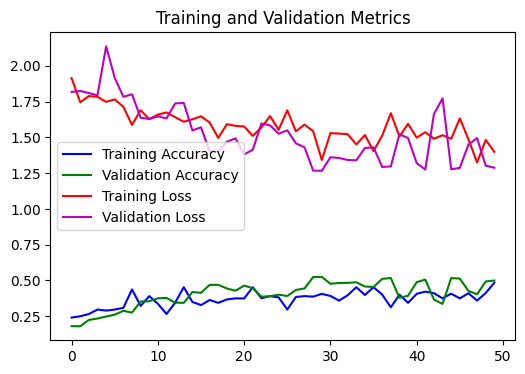

In [656]:
# Show the training artifacts
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'm', label='Validation Loss')

plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

In [657]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [658]:
y_true.shape

(3589,)

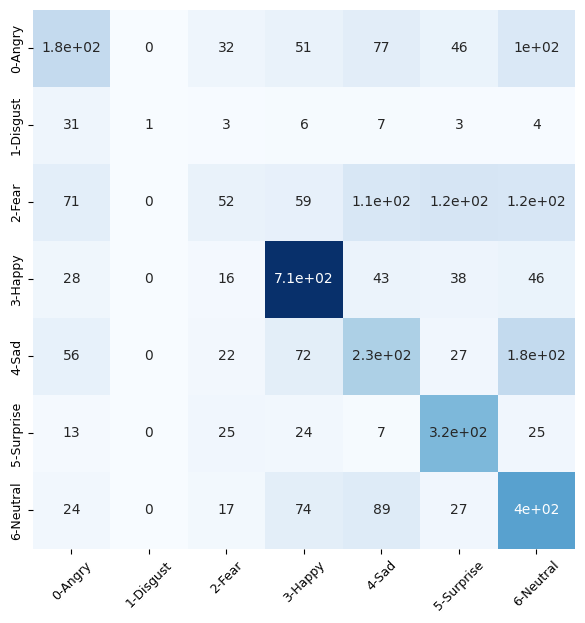

In [659]:
# Generate the confusion matrix for the true labels and the predicted classes
# label_to_text = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (7, 7))
labels = [f"{num}-{emotion}" for num, emotion in label_to_text.items()]
sns.heatmap(cm, annot = True, cbar = False, cmap = "Blues", xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=9)

plt.show()

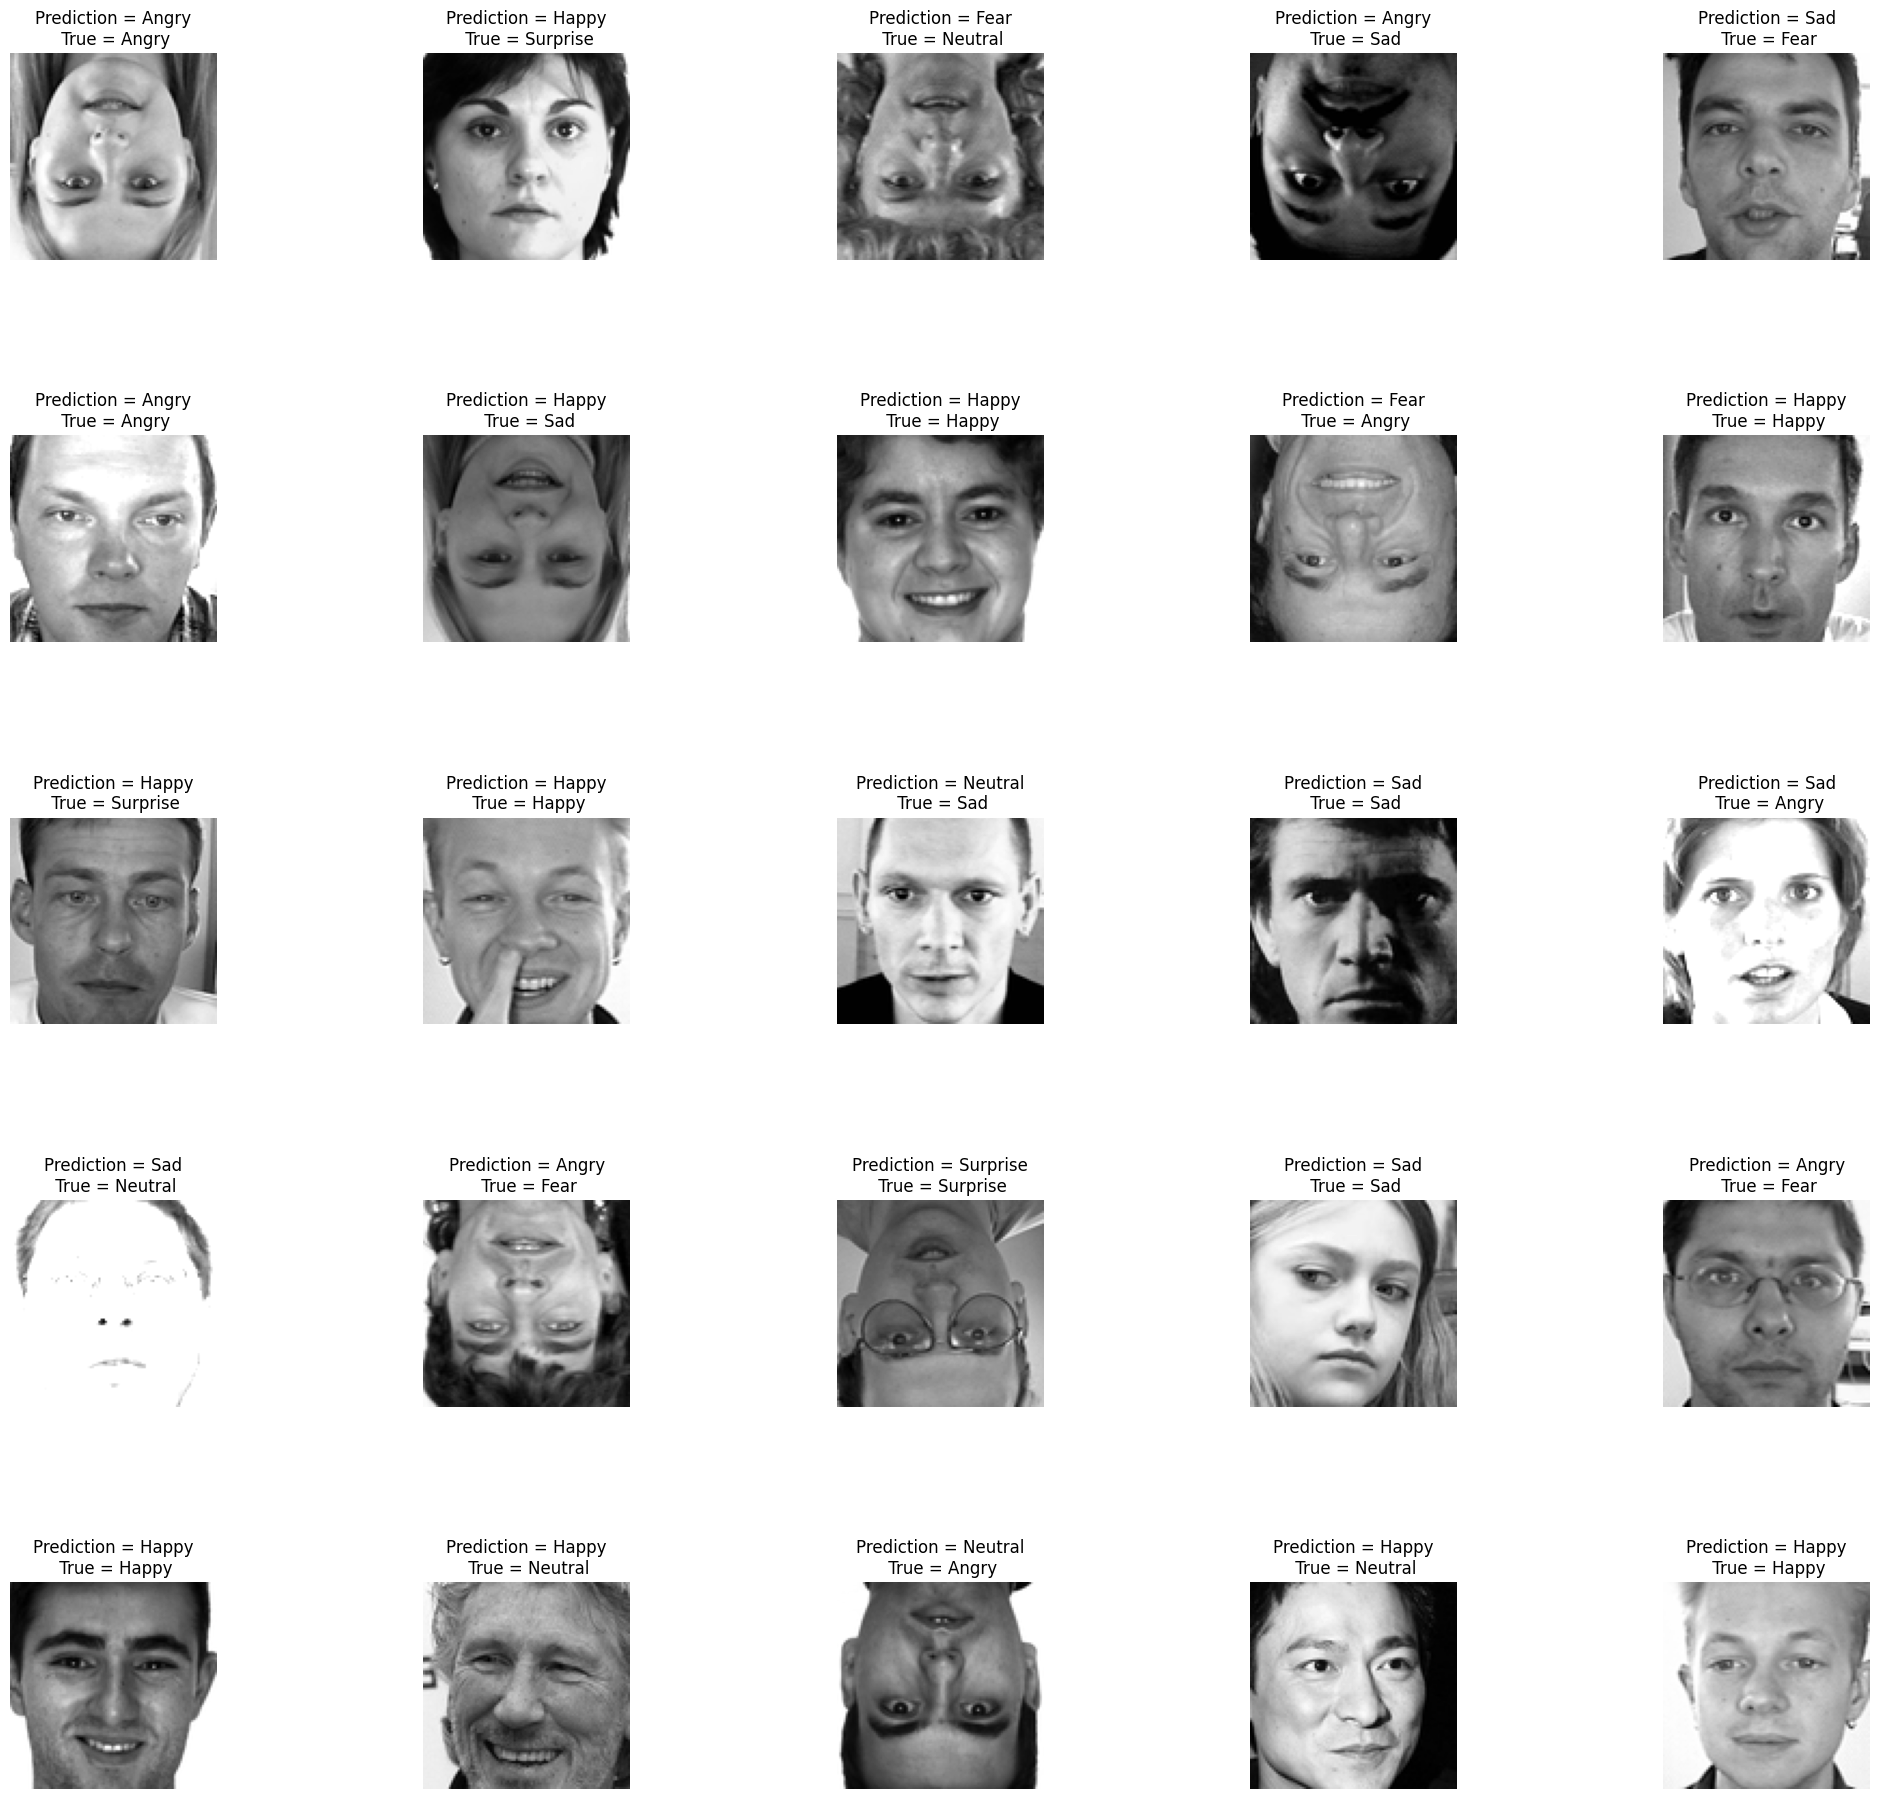

In [660]:
# Visualize the prediction by showig 25 images along with the predicted and true labels
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()
for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [666]:
# Generate a classification report for the true labels and predicted classes
# The report includes metrics such as precision, recall, f1-score, and support for each class
from sklearn.metrics import classification_report
report = classification_report(y_true, predicted_classes, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the report as a table
print(report_df)

              precision    recall  f1-score      support
0              0.448020  0.368635  0.404469   491.000000
1              1.000000  0.018182  0.035714    55.000000
2              0.311377  0.098485  0.149640   528.000000
3              0.712274  0.805461  0.756006   879.000000
4              0.411972  0.393939  0.402754   594.000000
5              0.552316  0.774038  0.644645   416.000000
6              0.452982  0.630990  0.527370   626.000000
accuracy       0.527445  0.527445  0.527445     0.527445
macro avg      0.555563  0.441390  0.417228  3589.000000
weighted avg   0.508084  0.527445  0.496417  3589.000000


## /******************************************** Part 3 ********************************************/
## Combine both Facial Emotion and Key Points Detection Models For Prediction

In [667]:
def predict(X_test):

  # Predict facial keypoints using the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Predict emotion using the emotion model and get the class with the highest probability
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshape the emotion predictions array from (856,) to (856,1) to match the shape of the facial keypoints predictions
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Convert the facial keypoints predictions to a DataFrame
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Add the emotion predictions to the DataFrame
  df_predict['emotion'] = df_emotion

  return df_predict

In [668]:
# Use the predict function to make predictions on the test set
df_predict = predict(X_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [669]:
# Display the first 5 rows of the predictions DataFrame
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,62.923672,60.656666,0.0,59.665291,56.996429,59.646885,68.360069,60.394264,35.557568,58.915436,...,39.452885,61.220581,24.398830,33.427280,23.785919,47.123981,27.667490,47.197372,15.316121,6
1,63.654381,34.110920,0.0,33.696152,56.718502,35.098976,70.884804,35.137962,35.227859,34.665550,...,51.683540,60.534840,71.860039,31.259018,71.688484,46.602642,67.010620,46.716461,76.184372,5
2,64.229904,60.301640,0.0,58.511089,58.484154,59.264114,69.824394,59.844421,35.907413,57.915455,...,42.777374,63.392387,23.959543,34.449421,22.386003,49.296021,27.926586,49.584999,14.548428,6
3,68.544205,61.818455,0.0,58.767128,60.965145,60.479500,75.308395,60.724697,34.232113,58.652668,...,43.770676,64.080215,16.640734,31.800373,14.205453,47.026119,23.642775,47.609283,7.955888,6
4,67.340599,35.039379,0.0,33.034870,60.736229,35.447517,74.019997,36.955139,34.175930,34.003521,...,48.736931,61.645164,75.080208,29.907314,73.593811,45.418613,67.239677,44.952282,83.321198,6


/var/folders/3f/lymqr3g15w5cjgqk0tykym400000gn/T/ipykernel_27982/799258557.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')


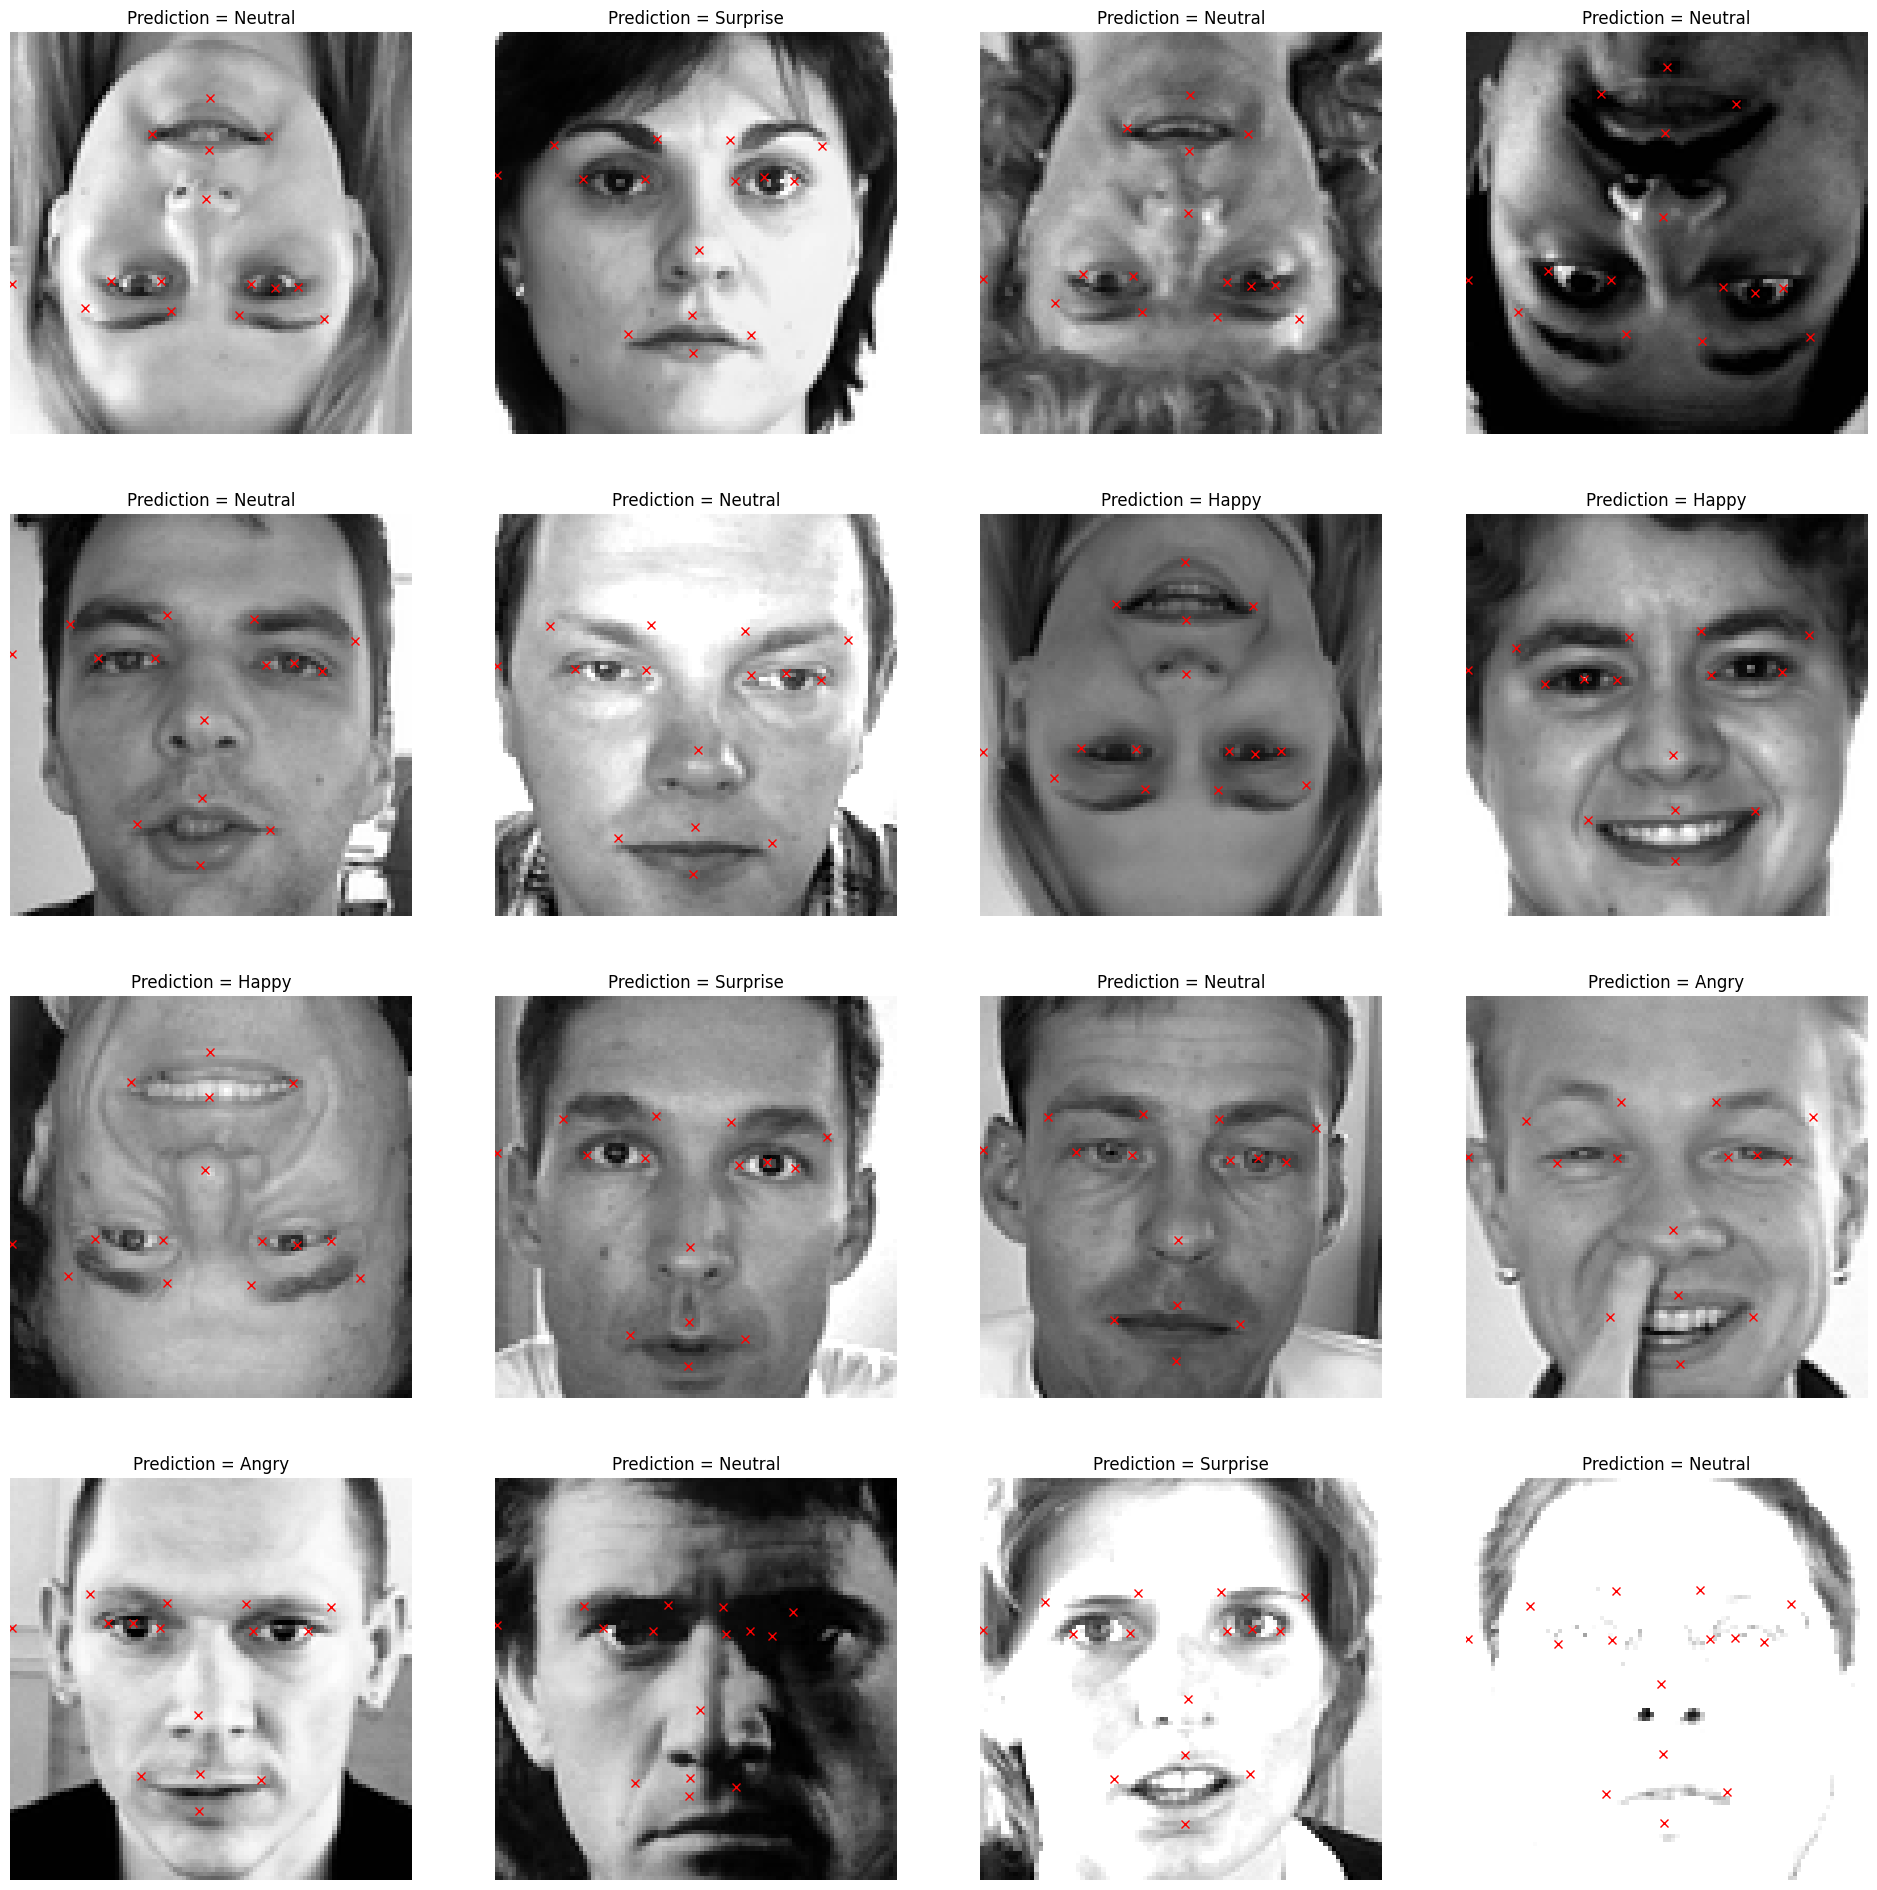

In [670]:
# Plot the test images and their predicted keypoints and emotions
fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()
for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

# Appendix

## Experiments
### 1. Facial Key Points Detection Model
#### 1.1 Dataset
Source: https://www.kaggle.com/c/facial-keypoints-detection/data
File location: ./dataset/data.csv
#### 1.2 Parameter Tuning and Performance
<img src="./media/Experimens-KeyPointsDetectionModel.png" width=1000px>

### 2. Facial Key Points Detection Model
#### 2.1 Dataset
Source: https://www.kaggle.com/datasets/ahmedmoorsy/facial-expression/data
File location: ./dataset/fer2013.csv
#### 2.2 Parameter Tuning and Performance
<img src="./media/Experimens-EmotionRecognitionModel.png" width=1000px>

## Future Work
The continued development of the CNN model will focus on several key areas:

* Dataset Balancing: Current methods for addressing the unbalanced dataset have proven inadequate. Future efforts will involve more extensive experimentation with class weighting strategies and exploring alternative methods to achieve a more balanced dataset.
* Integration with Key Points Detection Model: To enhance the emotion classification accuracy, we plan to develop a two-step model. This model will preprocess images by aligning faces based on key points detected by the Facial Key Points Detection model, followed by feeding these aligned images into the Emotion Recognition model.
* Model Performance Improvement: Given that the current model accuracy is unsatisfactory (less than 60%), we intend to conduct further experiments to adjust the model parameters and explore the use of various datasets to improve outcomes.
* Research on Existing Methods: We will continue to review and integrate findings from existing research on facial emotion classification to refine our approaches and incorporate successful techniques into our model development process.


